Importing all the necessary modules


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy as scipy
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar

 The current term structure of interest rates is imported.The yield curve is then constructed by inpterpolating for the intermediate values.Having the current yield for various maturity of bonds,the Hull White yield and HullWhite prices are then calculated.

In [3]:
def yield_curve_construction(tr, yr, time_step=0.25):
    t = list(i for i in np.arange(0.0, 30, time_step)) # interpolating in range 1..30 years
    y = []
    z = []
    interp = interp1d(tr, yr, bounds_error=False, fill_value=np.isnan)
    for i in t:
        value = float(interp(i))
        if not np.isnan(value): # Don't include out-of-range values
            y.append(value)
            z.append(np.exp(-i*value))
    return  t,y,z

def compute_HWZeroprice(r_t, kappa, sigma, Z_t, Z_T, F_t, t, T):
    B = (1 - np.exp(-kappa*(T-t))) / kappa
    A = np.log(Z_T/Z_t) + B*F_t - (sigma**2/(4*kappa**3))*((np.exp(-kappa*T) - np.exp(-kappa*t))**2)*(np.exp(2*kappa*t)-1)
    zero_price = np.exp(A - r_t * B)
    return zero_price

def compute_yield(r_t, kappa, sigma, Z_t, Z_T, F_t, t, T):
    zero_price = compute_HWZeroprice(r_t, kappa, sigma, Z_t, Z_T, F_t, t, T);
    yield_rate = -math.log(zero_price)/(T-t);
    return yield_rate

def get_instantaneous_fwd_rate(terms, zero_curve, T):
    interp = interp1d(terms, zero_curve, bounds_error=False, fill_value=scipy.nan)
    value1 = float(interp(T-0.001))
    value2 = float(interp(T+0.001))
    return -(np.log(value2)-np.log(value1))/0.002

def get_instantaneous_fwd_rate_slope(terms, zero_curve, T):
    interp = interp1d(terms, zero_curve, bounds_error=False, fill_value=scipy.nan)
    value1 = float(interp(T-0.001))
    value2 = float(interp(T+0.001))
    value3 = float(interp(T))
    return -(np.log(value2)-2*np.log(value3)+ np.log(value1))/0.000001



if __name__ == "__main__":
    NumSimulations = 100;
    r_t = 0.03; kappa = 38.0; sigma = 0.1; t = 0.0; T = 5.0; time_steps=500;   
    
  # Setting the initial term structure
    tr = [0.0, 0.25,	 0.5,	0.75,	1,	1.5,	2,	3,	4,	5,	10,	20,	30]
    
    yr = [0.03, 0.002, 0.005,	0.007,	0.011,	0.015,	0.018,	0.02,	0.022,	0.025,	0.0288,	0.031,	0.034]
    fwd_rate=r_t
    terms,yields,zero_prices=yield_curve_construction(tr, yr, time_step=0.25)
    
    hull_yields = [0.03]
    for Mat in terms[1:]:
        #fwd_rate = get_instantaneous_fwd_rate(terms, zero_prices, Mat)
        fwd_rate = r_t
        index = int(Mat/0.25 - 1)
        hull_yields.append(compute_yield(r_t, kappa, sigma, zero_prices[0], zero_prices[index], fwd_rate, 0.0, Mat))
        
 

Plotting the hull yields and current term structure yields the following plot is obtained

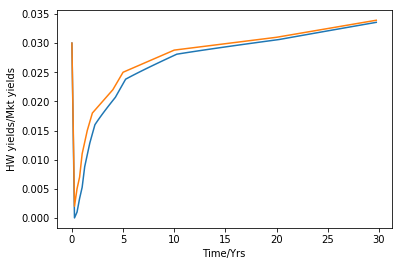

In [4]:
    plt.plot(terms,hull_yields, terms, yields)
    plt.xlabel ('Time/Yrs')
    plt.ylabel ('HW yields/Mkt yields')
    plt.show()

In [9]:
def objectif_function(kappa, r_t, sigma, terms, zero_prices, tr):
    Error = 0.0;
    for k in range(1,12):
        Maturity = tr[k];
        F_t = r_t
        index = int(Maturity/0.25 - 1)
        Mkt_price = zero_prices[index];
        HW_price = compute_HWZeroprice(r_t, kappa, sigma, zero_prices[index], 1.0, F_t, 0.0, Maturity)
        Error = Error +  (HW_price-Mkt_price)**2
    return Error

result = minimize_scalar(objectif_function, args=(r_t, sigma, terms, zero_prices, tr), bounds=(0.0,500.0), method='bounded')
print(result)
kappa_calib = result.x

     fun: 2.1044362576844318
 message: 'Solution found.'
    nfev: 36
  status: 0
 success: True
       x: 499.9999865167874


In [10]:
def HullWhite(r0,  terms, zero_curve, kappa, sigma, T=1.0, N=119, seed=777):    
    #np.random.seed(seed)
    dt = T/float(N)    
    rates = [r0]
    t = 0.0
    for i in range(1,N+1):
        t = t + dt;
        inst_fwd_slope = get_instantaneous_fwd_rate_slope(terms,zero_prices, t) 
        inst_fwd_rate  = get_instantaneous_fwd_rate(terms, zero_prices, t)
        eta_t =  inst_fwd_slope + inst_fwd_rate*kappa + sigma**2/(2*kappa)*(1-np.exp(-2*kappa*t))
        dr = (eta_t - kappa*rates[-1])*dt + sigma*np.random.normal()*math.sqrt(dt)
        rates.append(rates[-1] + dr)
    dates = [x*dt for x in range(N+1)];
    return dates, rates
r0 = 0.03; kappa =499; sigma = 0.1; t = 0.0; T = 5.0; time_steps=500;
date,rate=HullWhite(r0,  terms, zero_prices, kappa, sigma, T=1.0, N=100)


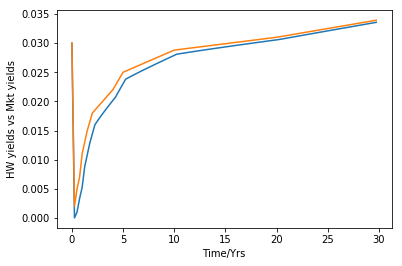

In [19]:
    r_t = 0.03; kappa =499; sigma = 0.1; t = 0.0; T = 5.0; 
    hull_yields = [0.03]
    for Mat in terms[1:]:
        #fwd_rate = get_instantaneous_fwd_rate(terms, zero_prices, Mat)
        fwd_rate = r_t
        index = int(Mat/0.25 - 1)
        hull_yields.append(compute_yield(r_t, kappa, sigma, zero_prices[0], zero_prices[index], fwd_rate, 0.0, Mat))
    plt.plot(terms,hull_yields, terms, yields)
    plt.xlabel ('Time/Yrs')
    plt.ylabel ('HW yields vs Mkt yields')
    plt.show()   